# Model interpretability

In [103]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'

import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')

# Modeling libraries
from sklearn.datasets import load_boston
import statsmodels.formula.api as smf 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')
import shap
shap.initjs()

import pandas as pd
np.random.seed(123)

import warnings
warnings.filterwarnings('ignore')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-Agnostic-feature-importances" data-toc-modified-id="Model-Agnostic-feature-importances-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model Agnostic feature importances</a></span><ul class="toc-item"><li><span><a href="#Permutation-test" data-toc-modified-id="Permutation-test-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Permutation test</a></span></li><li><span><a href="#SHAP-values" data-toc-modified-id="SHAP-values-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>SHAP values</a></span></li></ul></li><li><span><a href="#Tree-specific-methods" data-toc-modified-id="Tree-specific-methods-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Tree specific methods</a></span></li><li><span><a href="#References" data-toc-modified-id="References-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>References</a></span></li></ul></div>

In [ ]:
data = load_boston()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'], name='target')

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=123)
# Tune GBM
model = GradientBoostingRegressor(n_estimators=3000)

params = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
          'max_depth': [4, 6],
          'min_samples_leaf': [3, 5, 9, 17],
          'max_features': [1, 0.3, 0.1]}

grid_search = GridSearchCV(model,
                           param_grid=params,
                           cv=5,
                           n_jobs=3,
                           verbose=1)
grid_search.fit(X_train, y_train)

params = {'n_estimators': [1500, 2500, 3000, 3250, 3500, 4000],
          'learning_rate': np.logspace(-1, -3, num=10) * 3,
          'max_depth': [grid_search.best_params_['max_depth']],
          'min_samples_leaf': [grid_search.best_params_['min_samples_leaf']],
          'max_features': [grid_search.best_params_['max_features']]}
grid_search = GridSearchCV(model,
                           param_grid=params,
                           cv=5,
                           n_jobs=3,
                           verbose=1)

grid_search.fit(X_train, y_train)
print(f'Model score: {grid_search.score(X_test, y_test)}')

In [ ]:
{'learning_rate': 0.03874648995044652,
 'max_depth': 4,
 'max_features': 0.3,
 'min_samples_leaf': 3,
 'n_estimators': 3000}

## Model Agnostic feature importances

### Permutation test

[Read the docs](https://scikit-learn.org/stable/modules/permutation_importance.html)



CRIM - per capita crime rate by town
ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS - proportion of non-retail business acres per town.
CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
NOX - nitric oxides concentration (parts per 10 million)
RM - average number of rooms per dwelling
AGE - proportion of owner-occupied units built prior to 1940
DIS - weighted distances to five Boston employment centres
RAD - index of accessibility to radial highways
TAX - full-value property-tax rate per $10,000
PTRATIO - pupil-teacher ratio by town
B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT - % lower status of the population
MEDV - Median value of owner-occupied homes in $1000's

In [106]:
final_model = grid_search.best_estimator_
final_model.fit(X, y)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [114]:
from sklearn.inspection import permutation_importance


importances = permutation_importance(final_model, X, y, n_repeats=10, random_state=0)['importances']
importances = [np.mean(x) for x in importances]

In [120]:
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print(f"{f + 1} feature { X.columns[indices[f]]} ({importances[indices[f]]})" )


Feature ranking:
1 feature LSTAT (0.3592416479688759)
2 feature RM (0.29080241494376663)
3 feature DIS (0.07680794675768687)
4 feature NOX (0.05126834096233679)
5 feature PTRATIO (0.046976999352359695)
6 feature AGE (0.04217684210200492)
7 feature CRIM (0.027550914391664783)
8 feature TAX (0.022720876034482685)
9 feature B (0.014490251448135937)
10 feature INDUS (0.009640903873069272)
11 feature RAD (0.0027362526264159024)
12 feature ZN (0.001546726984073321)
13 feature CHAS (0.0006675065497316445)


### SHAP values

[Read the docs](https://github.com/slundberg/shap)

[Very nice video into the topic](https://www.youtube.com/watch?v=ngOBhhINWb8)

In [121]:
%%capture
!pip install shap

In [122]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)

In [123]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[380,:])

In [100]:
X[X.CRIM==X.CRIM.max()]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
380,88.9762,0.0,18.1,0.0,0.671,6.968,91.9,1.4165,24.0,666.0,20.2,396.9,17.21


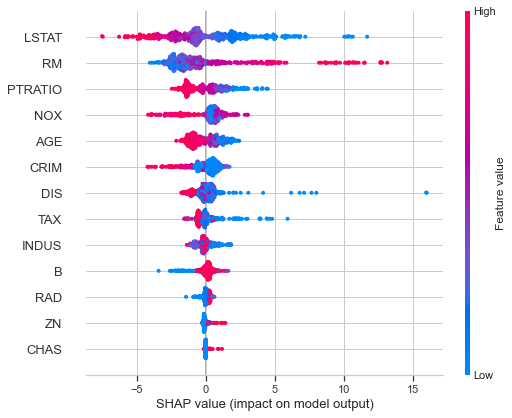

In [124]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X) # , plot_type="bar"

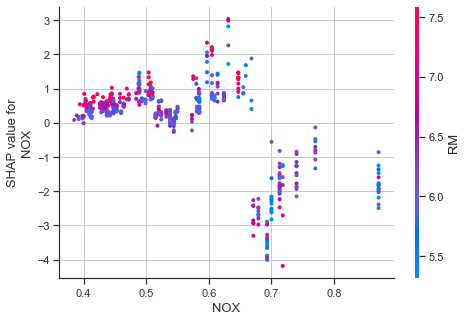

In [128]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('NOX', shap_values, X)

In [127]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

## Tree specific methods

In [130]:
for col, feat in zip(X.columns, final_model.feature_importances_):
    print(col, feat)

CRIM 0.07335476440171991
ZN 0.014257077958812928
INDUS 0.061010387856550816
CHAS 0.004095314026946395
NOX 0.08688854011587735
RM 0.24732339808091136
AGE 0.020854328446652554
DIS 0.06653026969849461
RAD 0.007097231846834643
TAX 0.05140265360842363
PTRATIO 0.08893551622076488
B 0.01496539853957792
LSTAT 0.2632851191984329


## References
* [Free book on the topic]()
